link to original notebook: 
https://deepnote.com/workspace/my-space-d003-e2bb83f7-45c6-44c1-9ca3-2d2fdded6f46/project/Welcome-7a0c0182-8404-4a4a-b0b7-199d3e510618/notebook/RosenbluthtoPERM-8a821b3752a2479488e724dbe1fcb727?utm_content=7a0c0182-8404-4a4a-b0b7-199d3e510618

this notebook explores the CPU version of PERM method.

Self-Avoiding Walk PERM Simulation (CPU Version)
-----------------------------------------------

Running PERM simulation with:
- Maximum walk length: 50
- Number of tours: 10000
Running PERM: 100%|██████████| 10000/10000 [59:44<00:00,  2.79tours/s]

Estimating connective constant...

Results:
- Estimated μ (connective constant): 2.597634
- Estimated γ (critical exponent): 1.625479

Known values from literature:
- μ: 2.6381585
- γ: 1.34375

Relative errors:
- μ error: 1.54%
- γ error: 20.97%

Generating plots...


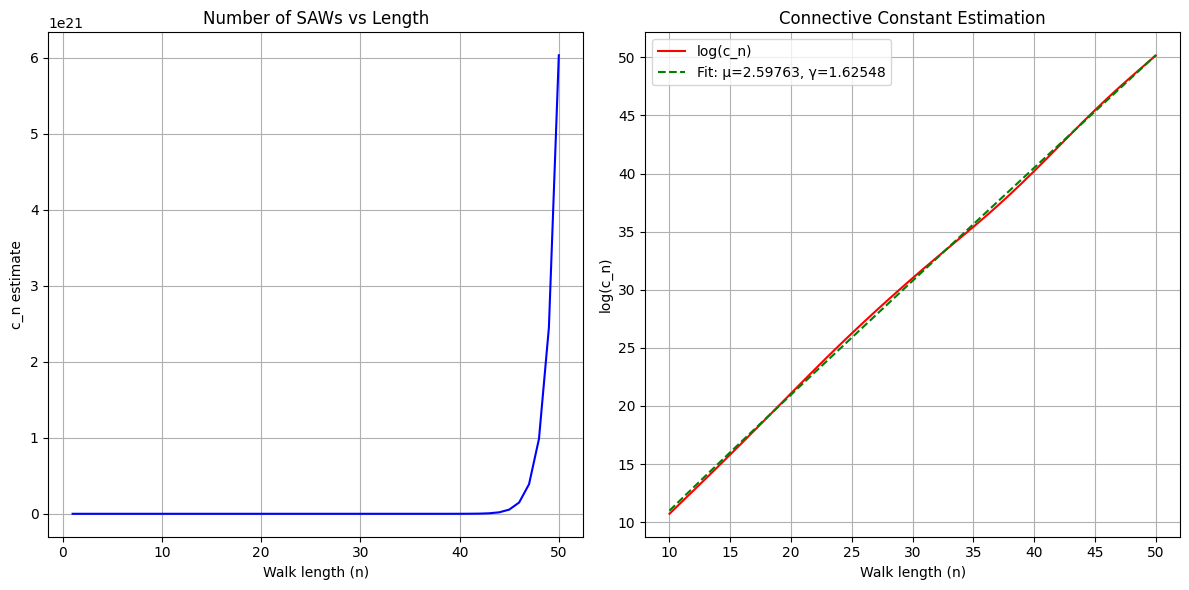


Simulation complete!


In [2]:
import numpy as np
import random
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

class PERM_SAW_CPU:
    def __init__(self, max_length, max_tours):
        self.max_length = max_length
        self.max_tours = max_tours
        self.reset_stats()
        
    def reset_stats(self):
        self.s = defaultdict(int)  # Sample counts
        self.w = defaultdict(float)  # Weight counts
        self.cn_estimates = np.zeros(self.max_length + 1)
        self.progress = tqdm(total=self.max_tours, desc="Running PERM", unit="tours")
        
    def is_valid_move(self, walk, new_pos):
        return not any(np.array_equal(new_pos, pos) for pos in walk)
    
    def grow_step(self, walk):
        current_pos = walk[-1]
        directions = [(1,0), (-1,0), (0,1), (0,-1)]
        possible_moves = [tuple(np.add(current_pos, d)) for d in directions]
        valid_moves = [pos for pos in possible_moves if self.is_valid_move(walk, pos)]
        return valid_moves
    
    def run(self):
        tours = 0
        while tours < self.max_tours:
            # Start new tour
            tours += 1
            self.progress.update(1)
            
            n = 0
            walk = [np.array([0,0])]  # Start at origin
            weight = 1.0
            copy_n = 1
            
            # Store initial state
            self.s[n] += 1
            self.w[n] += weight
            
            while n < self.max_length:
                valid_moves = self.grow_step(walk)
                a = len(valid_moves)
                
                if a == 0:  # Trapped, can't grow
                    copy_n = 0
                else:
                    # Pruning/enrichment
                    if n in self.w and self.w[n] > 0:
                        ratio = weight / (self.w[n] / self.s[n])
                        p = ratio - int(ratio)
                        if random.random() < p:
                            copy_n = int(ratio) + 1
                        else:
                            copy_n = int(ratio)
                        weight = self.w[n] / self.s[n]
                
                if copy_n == 0:  # Prune
                    # Backtrack to last enrichment point
                    while n > 0 and copy_n == 0:
                        walk.pop()
                        n -= 1
                    continue
                
                # Grow the walk
                copy_n -= 1
                if a > 0:
                    new_pos = random.choice(valid_moves)
                    walk.append(new_pos)
                    n += 1
                    weight *= a
                    
                    # Store data
                    self.s[n] += 1
                    self.w[n] += weight
        
        self.progress.close()
        
        # Calculate estimates for c_n
        for n in self.s:
            if self.s[n] > 0:
                self.cn_estimates[n] = self.w[n] / self.s[n]
                
        return self.cn_estimates

    def estimate_connective_constant(self, min_n=10, max_n=None):
        if max_n is None:
            max_n = self.max_length
        
        # Fit to log(c_n) = log(A) + n*log(μ) + (γ-1)*log(n)  
        # TODO: why is it γ-1?
        n_values = np.arange(min_n, max_n+1)
        log_cn = np.log(self.cn_estimates[min_n:max_n+1])
        log_n = np.log(n_values)
        
        # Linear regression
        A = np.vstack([n_values, log_n]).T  # [n, log(n)]
        b = log_cn
        x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
        
        log_mu = x[0]
        gamma_minus_1 = x[1]
        
        mu = np.exp(log_mu)
        gamma = gamma_minus_1 + 1
        
        return mu, gamma
    
    def plot_results(self):
        plt.figure(figsize=(12, 6))
        
        # Plot c_n estimates
        plt.subplot(1, 2, 1)
        n_values = np.arange(1, self.max_length+1)
        plt.plot(n_values, self.cn_estimates[1:], 'b-', label='Estimated c_n')
        plt.xlabel('Walk length (n)')
        plt.ylabel('c_n estimate')
        plt.title('Number of SAWs vs Length')
        plt.grid(True)
        
        # Plot log(c_n) vs n for connective constant estimation
        plt.subplot(1, 2, 2)
        log_cn = np.log(self.cn_estimates[10:])
        n_values = np.arange(10, self.max_length+1)
        plt.plot(n_values, log_cn, 'r-', label='log(c_n)')
        
        # Plot the fitted line
        mu, gamma = self.estimate_connective_constant()
        fitted = np.log(mu)*n_values + (gamma-1)*np.log(n_values)
        plt.plot(n_values, fitted, 'g--', label=f'Fit: μ={mu:.5f}, γ={gamma:.5f}')
        
        plt.xlabel('Walk length (n)')
        plt.ylabel('log(c_n)')
        plt.title('Connective Constant Estimation')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    print("Self-Avoiding Walk PERM Simulation (CPU Version)")
    print("-----------------------------------------------")
    
    # Parameters
    max_length = 50
    max_tours = 10000
    
    print(f"\nRunning PERM simulation with:")
    print(f"- Maximum walk length: {max_length}")
    print(f"- Number of tours: {max_tours}")
    
    # Run simulation
    perm_cpu = PERM_SAW_CPU(max_length, max_tours)
    cn_estimates = perm_cpu.run()
    
    # Estimate connective constant
    print("\nEstimating connective constant...")
    mu, gamma = perm_cpu.estimate_connective_constant()
    
    print(f"\nResults:")
    print(f"- Estimated μ (connective constant): {mu:.6f}")
    print(f"- Estimated γ (critical exponent): {gamma:.6f}")
    
    # Compare with known values
    known_mu = 2.6381585  # From literature
    known_gamma = 1.34375  # 43/32
    
    print(f"\nKnown values from literature:")
    print(f"- μ: {known_mu:.7f}")
    print(f"- γ: {known_gamma:.5f}")
    
    print(f"\nRelative errors:")
    print(f"- μ error: {abs(mu - known_mu)/known_mu*100:.2f}%")
    print(f"- γ error: {abs(gamma - known_gamma)/known_gamma*100:.2f}%")
    
    # Plot results
    print("\nGenerating plots...")
    perm_cpu.plot_results()
    
    print("\nSimulation complete!")